# Sea ice-water discrimination
Along with ice floes, we want to be able to distinguish, where possible, the water and ice pixels in each image. This will help us test a few steps in the IFT algorithm, for example. To avoid needing to manually draw the masks in Photoshop, I'd like to see whether it's possible to merge the existing masks and derive some information based on the Normalized Difference Snow and Ice Index (NDSII). Whereas the floe labels will sometimes include heavily obscured images, the ice/water masks will only include locations where the sea ice and water can be distinguished with high confidence.

In [3]:
import numpy as np
import os
import pandas as pd
import proplot as pplt
import rasterio as rio
from rasterio.plot import reshape_as_image
from sklearn.model_selection import KFold
import skimage
from scipy.interpolate import interp1d

# preliminaries
region_order = ['greenland_sea', 'barents_kara_seas', 'laptev_sea', 'sea_of_okhostk',
                'east_siberian_sea', 'bering_chukchi_seas', 'beaufort_sea', 'hudson_bay', 'baffin_bay']

title_case = {'baffin_bay': 'Baffin Bay',
              'barents_kara_seas': 'Barents-Kara Seas',
              'beaufort_sea': 'Beaufort Sea',
              'bering_chukchi_seas': 'Bering-Chukchi Seas',
              'east_siberian_sea': 'East Siberian Sea',
              'greenland_sea': 'Greenland Sea',
              'hudson_bay': 'Hudson Bay',
              'laptev_sea': 'Laptev Sea',
              'sea_of_okhostk': 'Sea of Okhostk'}

# load the list of cloud clearing evaluation cases
dataloc = '../../ice_floe_validation_dataset/'
df = pd.read_csv(dataloc + '/data/validation_dataset/validation_dataset.csv')
df['case_number'] = [str(cn).zfill(3) for cn in df['case_number']]
df.groupby('region').count()
df['start_date'] = pd.to_datetime(df['start_date'].values)
df.index = [cn + '_' + sat for cn, sat in zip(df.case_number, df.satellite)]

def fname(case_data, imtype='labeled_floes'):
    """Generates filenames from rows in the overview table. imtype can be 'labeled_floes', 
    'binary_floes', 'binary_landfast', or 'binary_landmask', 'truecolor', or 'falsecolor'.
    The imtype determines whether a 'png' or 'tiff' is returned.
    """

    cn = case_data['case_number']
    date = pd.to_datetime(case_data['start_date']).strftime('%Y%m%d')
    region = case_data['region']
    sat = case_data['satellite']
    if 'binary' in imtype:
        return  '-'.join([cn, region, date, sat, imtype + '.png'])
        
    elif imtype in ['truecolor', 'falsecolor', 'cloudfraction', 'labeled_floes',]:
        prefix = '-'.join([cn, region, '100km', date])
        return '.'.join([prefix, sat, imtype, '250m', 'tiff'])

    elif imtype in ['seaice', 'landmask',]:
        prefix = '-'.join([cn, region, '100km', date])
        return '.'.join([prefix, 'masie', imtype, '250m', 'tiff'])        

In [4]:
# Load raster data and masks
fc_dataloc = dataloc + 'data/modis/falsecolor/'
tc_dataloc = dataloc + 'data/modis/truecolor/'
cl_dataloc = dataloc + 'data/modis/cloudfraction/'

lm_dataloc = dataloc + 'data/validation_dataset/binary_landmask/'
lb_dataloc = dataloc + 'data/validation_dataset/binary_floes/'
lf_dataloc = dataloc + 'data/validation_dataset/binary_landfast/'

masie_ice_loc = dataloc + 'data/masie/seaice/'
masie_land_loc = dataloc + 'data/masie/landmask/'

tc_images = {}
fc_images = {}
cl_images = {}
lb_images = {}
lf_images = {}
lm_images = {}
mi_images = {}
ml_images = {}

missing = []
for row, data in df.iterrows():
    for datadir, imtype, data_dict in zip([tc_dataloc, fc_dataloc, cl_dataloc,
                                           lb_dataloc, lf_dataloc, lm_dataloc,
                                           masie_ice_loc, masie_land_loc],
                                          ['truecolor', 'falsecolor', 'cloudfraction',
                                           'binary_floes', 'binary_landfast', 'binary_landmask',
                                           'seaice', 'landmask'],
                                          [tc_images, fc_images, cl_images,
                                           lb_images, lf_images, lm_images,
                                           mi_images, ml_images]):
        try:
            with rio.open(datadir + fname(df.loc[row,:], imtype)) as im:
                data_dict[row] = im.read()
        except:
            if imtype in ['falsecolor', 'cloudfraction', 'landmask']:
                print('Couldn\'t read', fname(df.loc[row,:], imtype), imtype)
            elif imtype == 'binary_floes':
                if df.loc[row, 'visible_floes'] == 'yes':
                    missing.append(fname(df.loc[row,:], imtype))
            elif imtype == 'binary_landfast':
                if df.loc[row, 'visible_landfast_ice'] == 'yes':
                    missing.append(fname(df.loc[row,:], imtype))
            elif imtype in ['seaice', 'landmask']: # masie images
                missing.append(fname(df.loc[row,:], imtype))

/opt/miniconda3/envs/calval/lib/python3.9/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [10]:
# df.loc[df.cloud_fraction_manual < 0.2]['case_number']

CaseName     Number  WaterMask
005_terra    005    
006_terra    006     75
006_aqua     006
011_aqua     011
011_terra    011
012_aqua     012
014_aqua     014
014_terra    014
018_aqua     018
025_aqua     025
032_aqua     032
032_terra    032
048_aqua     048
048_terra    048
054_aqua     054
054_terra    054
063_aqua     063
063_terra    063
071_terra    071
088_terra    088
105_aqua     105
111_terra    111
128_aqua     128
128_terra    128
134_aqua     134
134_terra    134
136_aqua     136
136_terra    136
138_aqua     138
138_terra    138
152_aqua     152
155_aqua     155
166_aqua     166
166_terra    166
169_aqua     169
169_terra    169
176_terra    176
181_aqua     181

/opt/miniconda3/envs/calval/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


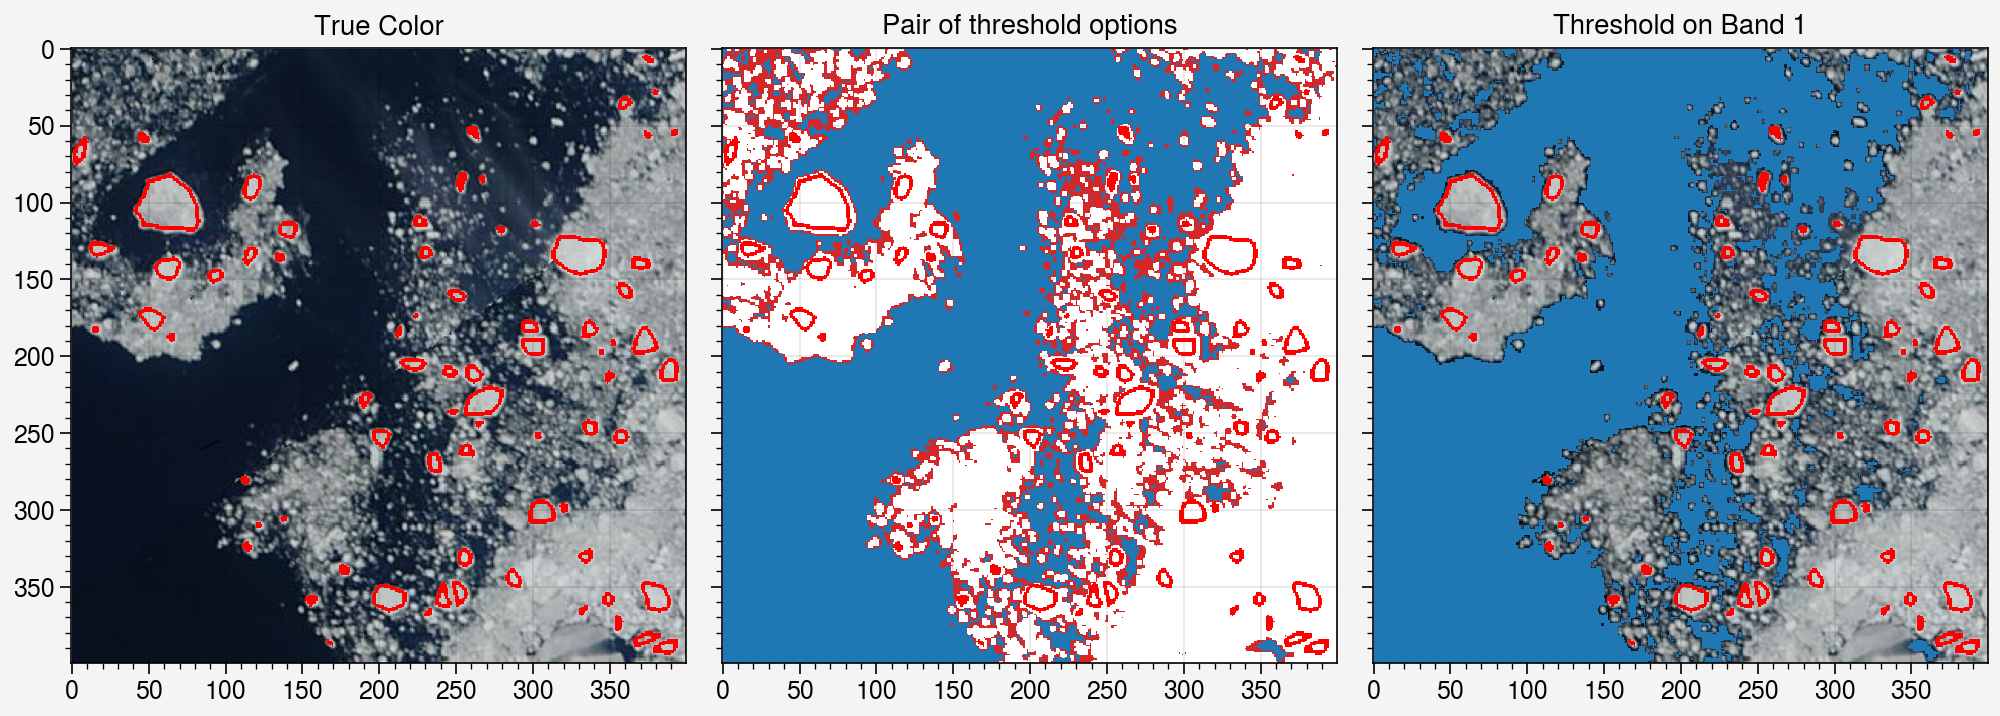

In [85]:
case = '011_terra'
b1 = fc_images[case][2, :, :]
b7 = fc_images[case][0, :, :]
b2 = fc_images[case][1, :, :]
b4 = tc_images[case][1, :, :]

threshold = 25

fig, axs = pplt.subplots(width=10, ncols=3)
axs[0].imshow(reshape_as_image(tc_images[case]), extent=[0, 400, 400, 0])
land = (lm_images[case].squeeze() > 0).astype(int)
axs[0].imshow(np.ma.masked_array(land, land==0), color='gold', alpha=1, extent=[0, 400, 400, 0], zorder=10)
axs[1].imshow(np.ma.masked_array((b1 > 75).astype(int),mask=b1 > 75), color='tab:red', extent=[0, 400, 400, 0], zorder=2)

axs[1].imshow(np.ma.masked_array((b1 > threshold).astype(int),mask=b1 > threshold), color='tab:blue', 
              extent=[0, 400, 400, 0], zorder=2)

if case in lb_images:
    manual_floe_labels = lb_images[case][0,:,:] % 2
    outlines = manual_floe_labels - skimage.morphology.erosion(manual_floe_labels, skimage.morphology.disk(4))
else:
    manual_floe_labels = np.zeros_like(lb_images['011_aqua'][0,:,:])
axs[2].imshow(reshape_as_image(tc_images[case]), extent=[0, 400, 400, 0])

axs[2].imshow(np.ma.masked_array((b1 > threshold).astype(int),mask=b1 > threshold), color='tab:blue', extent=[0, 400, 400, 0], zorder=2)

for ax in axs:
    ax.imshow(np.ma.masked_array(land, land==0), color='k', alpha=0.75, extent=[0, 400, 400, 0], zorder=1)
    if case in lb_images:
        ax.imshow(np.ma.masked_array(outlines, outlines==0), color='r', zorder=4)
    # add landfast?
axs[0].format(title='True Color')
axs[1].format(title='Pair of threshold options')
axs[2].format(title='Threshold on Band 1')

In [86]:
manual_floe_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

The histogram of water color tapers out above 30, while the sea ice floes tend to be above 100. A tie breaking approach could be used based on the histogram. The water fraction is sensitive to the choice of threshold. Basically the question is what the upper threshold should be, which includes pixels with mixed ice and water. The difference from 25 to 100 for the water threshold leads to a 16% change in the water fraction for case 11, which is fairly large! That's one reason it's so important to be confident in whether the image has clear skies, and why we need to be clear about the composition in a pixel, which we can only somewhat do based on the data.

In [87]:
for thresh in [25, 50, 75, 100]:
    water = np.ravel(b1) > thresh
    water = water[np.ravel(land == 0)] 
    print(thresh, np.mean(water))

25 0.50911875
50 0.43150625
75 0.38080625
100 0.339525


In [92]:
np.percentile(np.ravel(b1[manual_floe_labels > 0]), 0.05)

23.0

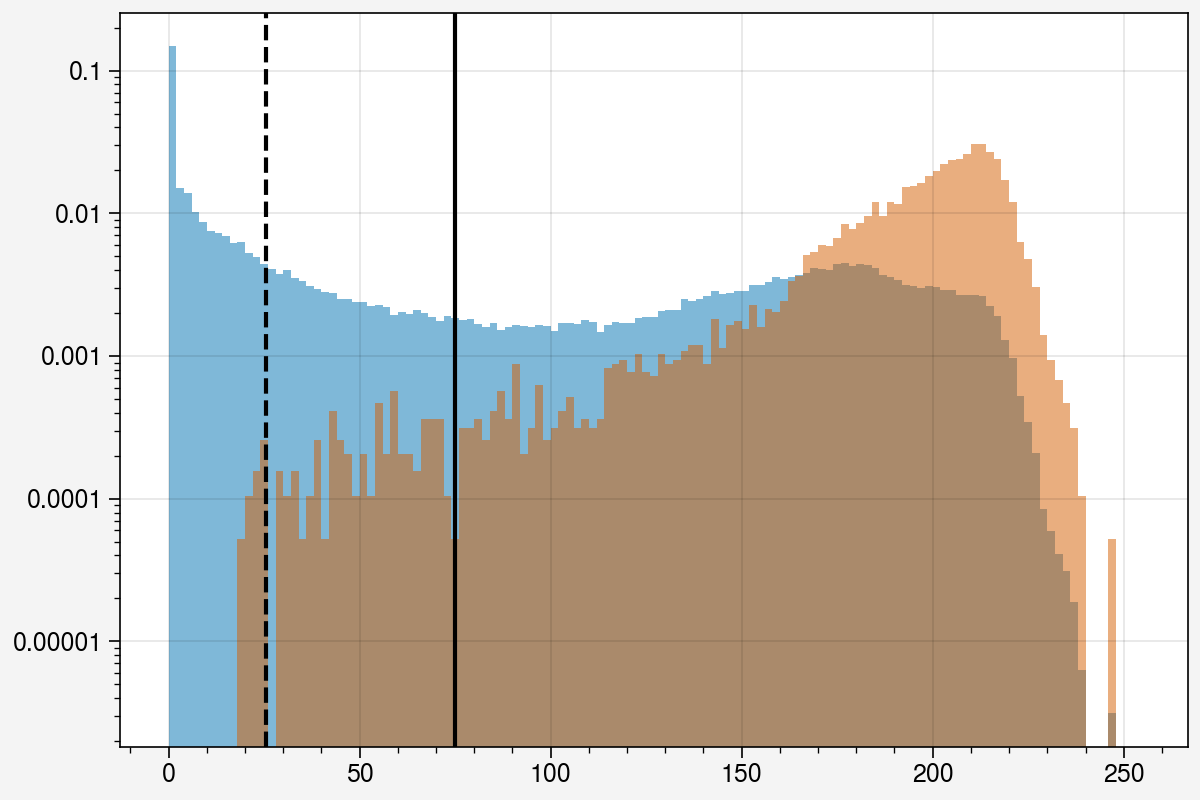

In [91]:
fig, ax = pplt.subplots(width=6, height=4)
_ = ax.hist(np.ravel(b1), bins=range(0, 256, 2), density=True, alpha=0.5)
_ = ax.hist(np.ravel(b1[manual_floe_labels > 0]), bins=range(0, 256, 2), density=True, alpha=0.5)
ax.format(yscale='log')
ax.axvline(25.5, c='k', ls='--')
ax.axvline(75, c='k', ls='-')

Method:
- Water mask: less than threshold on band 1
- Ice mask: greater than threshold on band 1
- Could use a tie-break approach, with the minimum in the band 1 brightness. That's been used in prior literature.
  - e.g.; cloud-free pixels larger than 100. If a peak exists, call that the sea ice peak.  Use half that value as a water / mixed ice maximum. Then, less than X = percentile of the data below the maximum is water, and the rest are mixed water-ice pixels? 

array([231, 227, 237, ..., 156, 158, 170], dtype=uint8)

# Notes on interesting cases
* 001: sharp difference in cloud vs water pixels. Ice NDSII midrange.
* 002: no distinct floes; ice formation in fjord. Ice NDSII near 1.
* 003: no distinct floes, small patch of discernable water, landfast ice NDSII near 1.
* 005: Landfast ice saturated; clouds also saturated. Sea ice pixels all above 0.4.
* 007: Band 1 threshold works pretty well, NDSII ambiguous.
* 012: thin clouds over water, so a higher threshold needed
* 025: Ocean pixels all at 1??
* 048: Ocean pixels hit extremes. Is the formula correct? Here, using a threshold of 50 on band 1 seems pretty effective.

Next steps, for 048, look at the histograms in particular bands.

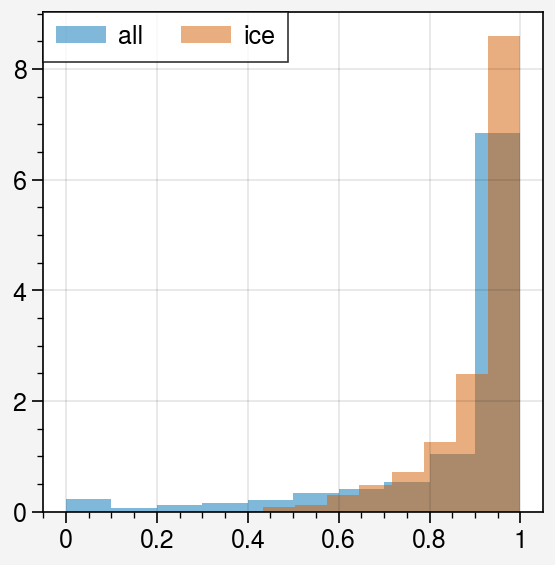

In [5]:
fig, ax = pplt.subplots()
ndsii[ndsii >= 1] = 1
ice = np.ravel(lb_images[case][0,:,:] > 0)

ax.hist(np.ravel(ndsii), density=True, alpha=0.5, label='all')
ax.hist(np.ravel(ndsii)[ice], density=True, alpha=0.5, label='ice')
ax.legend()

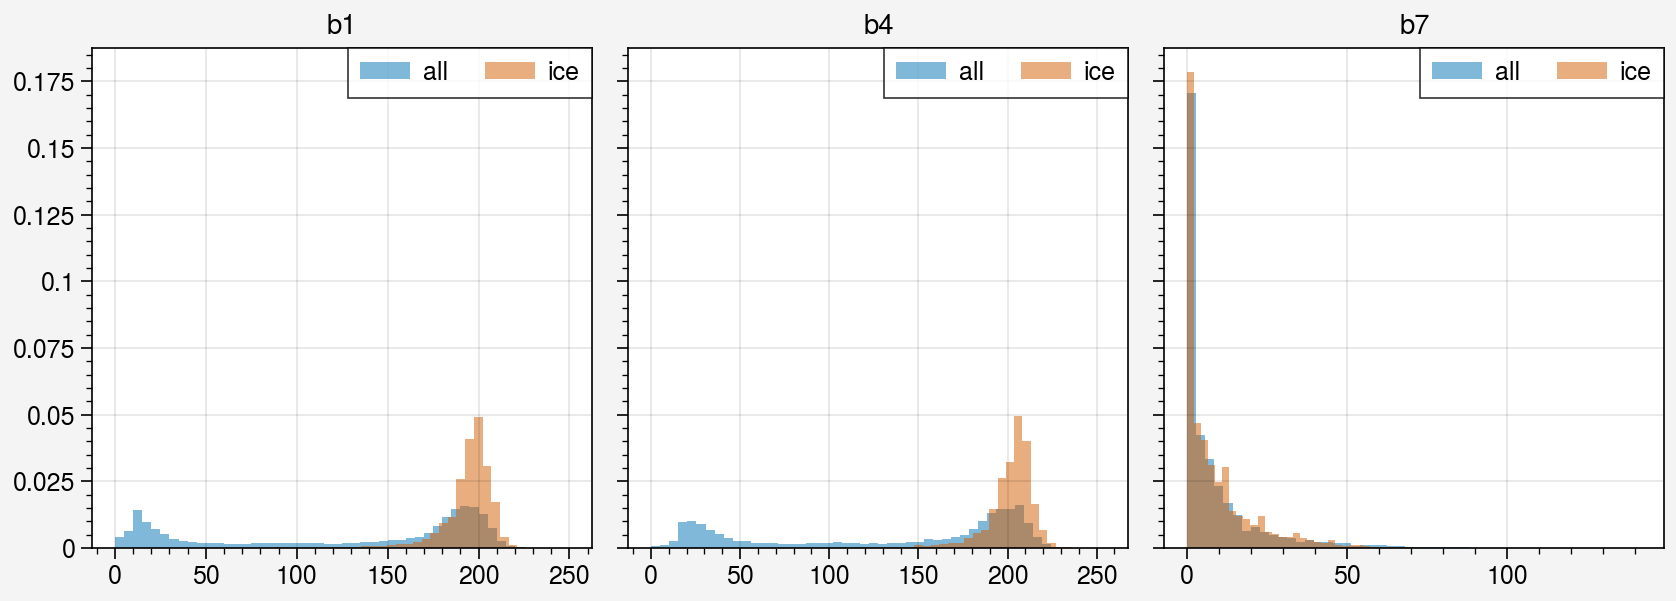

In [6]:
fig, axs = pplt.subplots(ncols=3)
b1 = tc_images[case][0,:,:]
b4 = tc_images[case][1,:,:]
b2 = fc_images[case][1,:,:]
b7 = fc_images[case][0,:,:]
ice = np.ravel(lb_images[case][0,:,:] > 0)
for ax, b, title in zip(axs, [b1, b4, b7], ['b1', 'b4', 'b7']):
    ax.hist(np.ravel(b), density=True, alpha=0.5, label='all', bins=50)
    ax.hist(np.ravel(b)[ice], density=True, alpha=0.5, label='ice', bins=50)
    ax.legend()
    ax.format(title=title)

In [94]:
bandwidths = {'b1': 0.5 * (620 + 670), 
              'b2': 0.5 * (841 + 876), 
              'b3': 0.5 * (459 + 479), 
              'b4': 0.5 * (545 + 565),
              'b7': 0.5 * (2105 + 2155)}
print(bandwidths)

{'b1': 645.0, 'b2': 858.5, 'b3': 469.0, 'b4': 555.0, 'b7': 2130.0}


An update of the figure below would provide a good reference for choosing thresholds for colors for the foreground/background question. I'd like to see if there is a range that is essentially always 

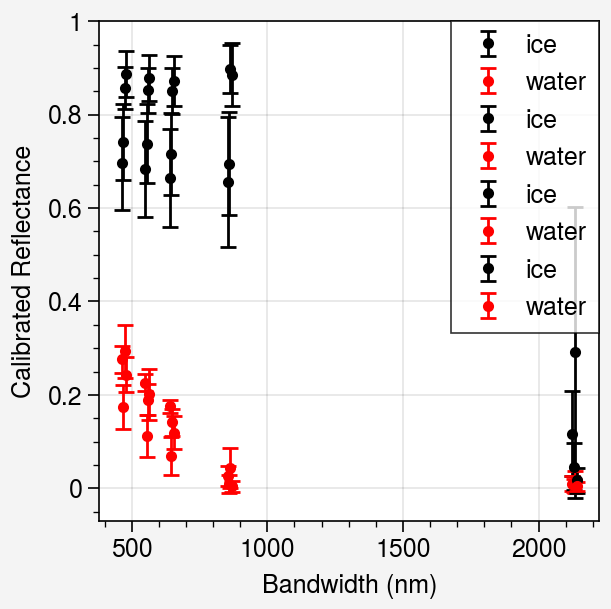

In [95]:
fig, ax = pplt.subplots()
offset = -5
for case in ['004_terra', '011_terra', '013_terra', '048_terra']:
    land = np.ravel(lm_images[case][0,:,:] > 0)
    banddata = {
        'b1': tc_images[case][0,:,:]/255,
        'b2': fc_images[case][1,:,:]/255,
        'b3': tc_images[case][2,:,:]/255,
        'b4': tc_images[case][1,:,:]/255,
        'b7': fc_images[case][0,:,:]/255}
    
    
    ice = lb_images[case][0,:,:] > 0
    water = (banddata['b1'] < 50/255) & (lm_images[case][0,:,:] == 0)
    
    
    for category, label, c in zip([ice, water], ['ice', 'water'], ['k', 'r']):
        bw = [bandwidths[band] + offset for band in bandwidths]
        bmean = [np.mean(banddata[band][category]) for band in bandwidths]
        bstd = [np.std(banddata[band][category]) for band in bandwidths]
        ax.errorbar(x=bw, y=bmean, yerr=bstd, lw=0, marker='.', elinewidth=1, label=label, color=c)
    offset += 5
    ax.legend(ncols=1)
    ax.format(xscale='linear', xlabel='Bandwidth (nm)', ylabel='Calibrated Reflectance')
    
    # TBD: get cloud labels also
    # See about ways to aggregate across images, check differences in season

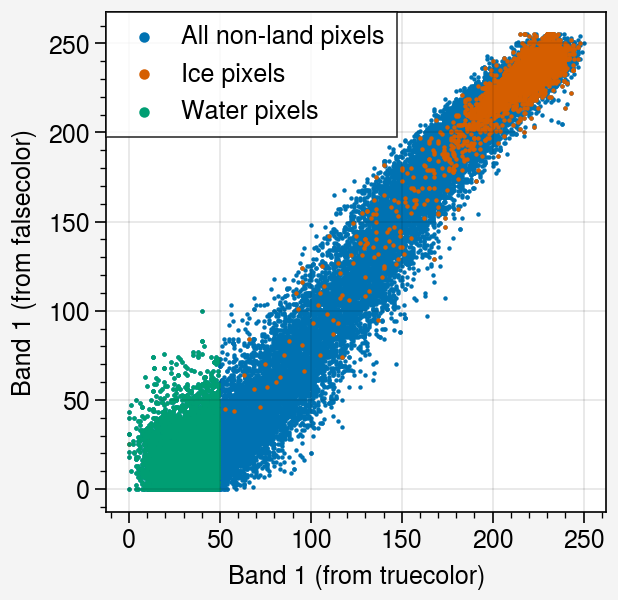

In [9]:
fig, ax = pplt.subplots()
land = np.ravel(lm_images[case][0,:,:] > 0)
ice = np.ravel(lb_images[case][0,:,:] >0)
water = np.ravel(tc_images[case][0,:,:] < 50)

ax.scatter(np.ravel(tc_images[case][0,:,:])[~land],
           np.ravel(fc_images[case][2,:,:])[~land], ms=1, label='All non-land pixels')


ax.scatter(np.ravel(tc_images[case][0,:,:])[ice],
           np.ravel(fc_images[case][2,:,:])[ice], ms=1, label='Ice pixels')
ax.scatter(np.ravel(tc_images[case][0,:,:])[water],
           np.ravel(fc_images[case][2,:,:])[water], ms=1, label='Water pixels')

ax.format(xlabel='Band 1 (from truecolor)', ylabel='Band 1 (from falsecolor)')
ax.legend(ncols=1, ms=10)

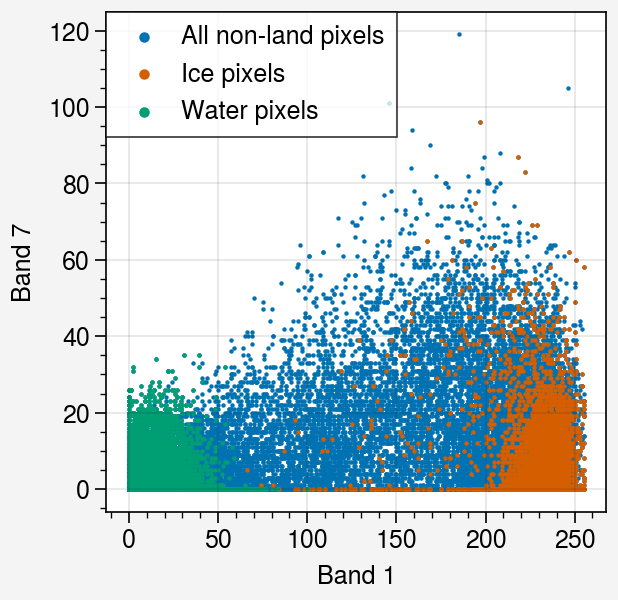

In [10]:
fig, ax = pplt.subplots()
land = np.ravel(lm_images[case][0,:,:] > 0)
ax.scatter(np.ravel(fc_images[case][2,:,:])[~land],
           np.ravel(fc_images[case][0,:,:])[~land], ms=1, label='All non-land pixels')

ice = np.ravel(lb_images[case][0,:,:] > 0)
ax.scatter(np.ravel(fc_images[case][2,:,:])[ice],
           np.ravel(fc_images[case][0,:,:])[ice], ms=1, label='Ice pixels')

ax.scatter(np.ravel(fc_images[case][2,:,:])[water],
           np.ravel(fc_images[case][0,:,:])[water], ms=1, label='Water pixels')
ax.format(xlabel='Band 1', ylabel='Band 7')
ax.legend(ncols=1, ms=10)

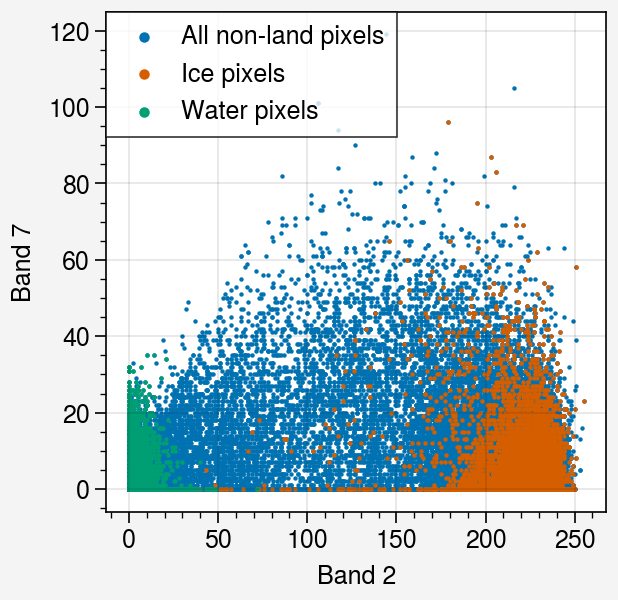

In [181]:
fig, ax = pplt.subplots()
land = np.ravel(lm_images[case][0,:,:] > 0)
ax.scatter(np.ravel(fc_images[case][1,:,:])[~land],
           np.ravel(fc_images[case][0,:,:])[~land], ms=1, label='All non-land pixels')

ice = np.ravel(lb_images[case][0,:,:] > 0)
ax.scatter(np.ravel(fc_images[case][1,:,:])[ice],
           np.ravel(fc_images[case][0,:,:])[ice], ms=1, label='Ice pixels')

ax.scatter(np.ravel(fc_images[case][1,:,:])[water],
           np.ravel(fc_images[case][0,:,:])[water], ms=1, label='Water pixels')

ax.format(xlabel='Band 2', ylabel='Band 7')
ax.legend(ncols=1, ms=10)

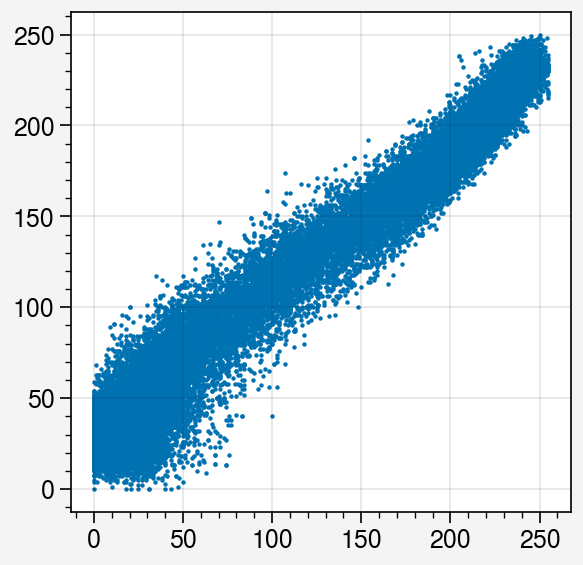

In [185]:
fig, ax = pplt.subplots()
land = np.ravel(lm_images[case][0,:,:] > 0)
ax.scatter(np.ravel(fc_images[case][2,:,:])[~land],
           np.ravel(tc_images[case][0,:,:])[~land], ms=1, label='All non-land pixels')
